# ABEL linac tracking example

By Carl A. Lindstrøm (University of Oslo), 8 Sep 2023

### Import ABEL framework

In [1]:
from abel import *
import numpy as np
%load_ext autoreload
%autoreload 2

### Define the linac and beams

In [4]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 42e-6 # [m]
driver.z_offset = 300e-6 # [m]
driver.emit_nx, driver.emit_ny = 80e-6, 80e-6 # [m rad]
driver.beta_x, driver.beta_y = 0.2, 0.2 # [m]
driver.num_particles = 100000
driver.jitter.x = 1e-6 # [m]
driver.jitter.t = 10e-15 # [s]

# define stage
stage = StageQuasistatic2d()
#stage = StageBasic()
stage.driver_source = driver
stage.nom_energy_gain = 31.9e9 # [eV]
stage.nom_accel_gradient = 6.4e9 # [GV/m]
stage.plasma_density = 7e21 # [m^-3]
stage.ramp_beta_mag = 10
stage.enable_radiation_reaction = False
stage.upramp = stage.__class__()
stage.downramp = stage.__class__()

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 5e9 # [eV]
source.rel_energy_spread = 0.01
source.bunch_length = 18e-6 # [m]
source.z_offset = -36e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 10000

# define interstage
interstage = InterstagePlasmaLensBasic()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.R56 = lambda E: -0.5e-3 / np.sqrt(E/10e9) # [m(eV)]
interstage.length_dipole = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.field_dipole = lambda E: np.min([1.0, 100e9/E]) # [T]

# define linac
linac = PlasmaLinac()
linac.source = source
linac.stage = stage
linac.interstage = interstage
linac.num_stages = 16

### Run simulations

In [5]:
linac.run('linac_example', num_shots=1, overwrite=True, parallel=False);

Tracked #0  SourceBasic             (s =    0.0 m) :   E =   5.0 GeV, Q = -1.60 nC, σz =  17.7 µm, σE =  1.0%, ε =159.37/  0.56 mm-mrad
    ... #1  StageQuasistatic2d #1   (s =    5.0 m) :   E =  36.1 GeV, Q = -1.60 nC, σz =  17.7 µm, σE =  3.8%, ε =159.99/  0.56 mm-mrad
    ... #2  InterstagePlasmaLensBasic (s =   16.5 m) :   E =  36.1 GeV, Q = -1.60 nC, σz =  12.7 µm, σE =  3.8%, ε =159.99/  0.56 mm-mrad
    ... #3  StageQuasistatic2d #2   (s =   21.5 m) :   E =  69.3 GeV, Q = -1.60 nC, σz =  12.7 µm, σE =  2.3%, ε =163.26/  0.57 mm-mrad
    ... #4  InterstagePlasmaLensBasic (s =   37.2 m) :   E =  69.3 GeV, Q = -1.60 nC, σz =  15.1 µm, σE =  2.3%, ε =163.26/  0.57 mm-mrad
    ... #5  StageQuasistatic2d #3   (s =   42.2 m) :   E = 100.2 GeV, Q = -1.60 nC, σz =  15.1 µm, σE =  1.6%, ε =164.51/  0.57 mm-mrad
    ... #6  InterstagePlasmaLensBasic (s =   61.3 m) :   E = 100.2 GeV, Q = -1.60 nC, σz =  16.8 µm, σE =  1.6%, ε =164.51/  0.57 mm-mrad
    ... #7  StageQuasistatic2d #4   (s =  

### Plot the wakefield

No evolution calculated


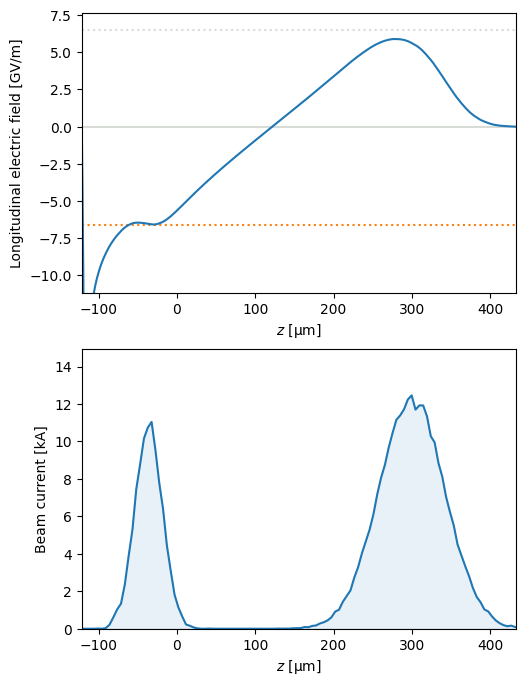

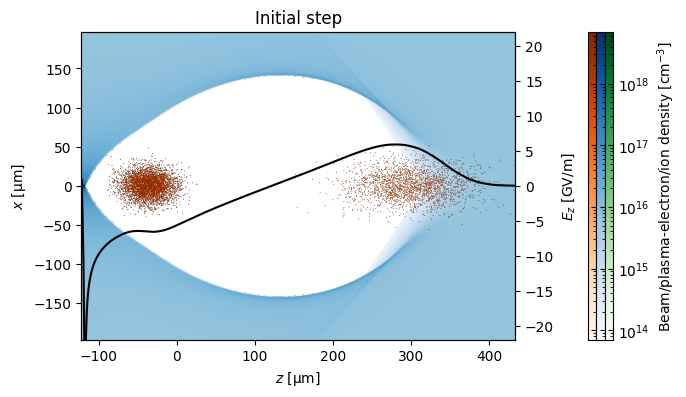

In [6]:
# plot the first-stage wakefield
linac.first_stage.plot_wakefield()
linac.first_stage.plot_wake()
linac.first_stage.plot_evolution()

No evolution calculated


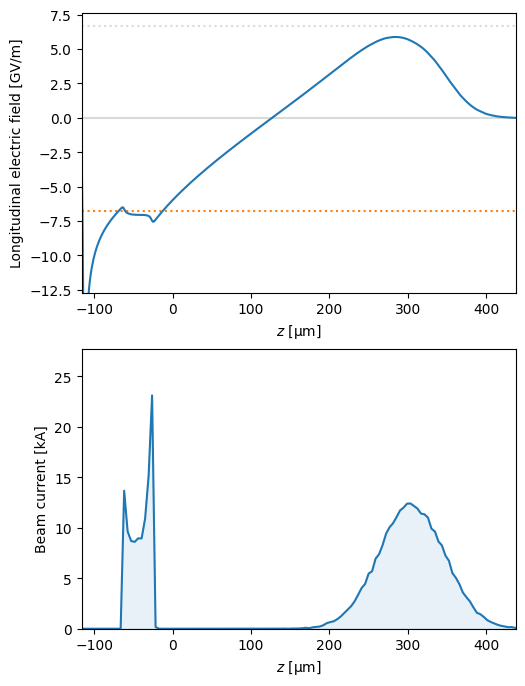

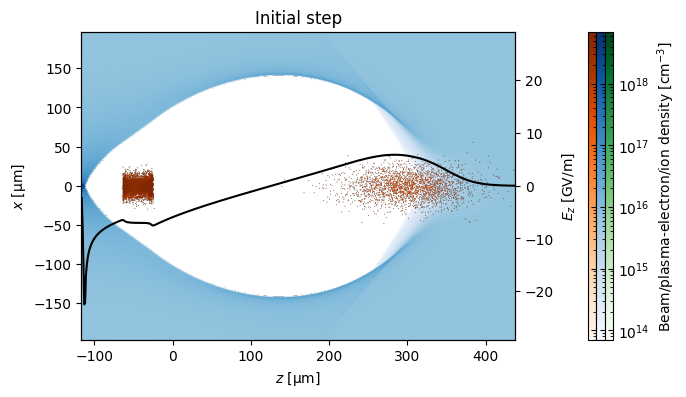

In [7]:
# plot the last-stage wakefield
linac.stages[1].plot_wakefield()
linac.stages[1].plot_wake()
linac.stages[1].plot_evolution()

No evolution calculated


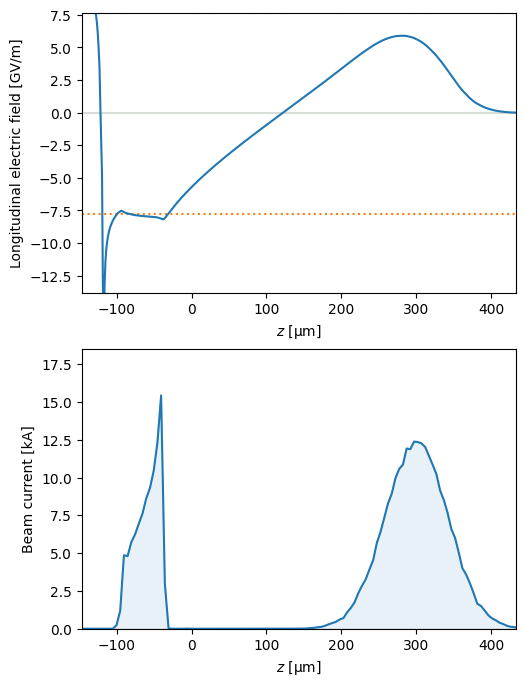

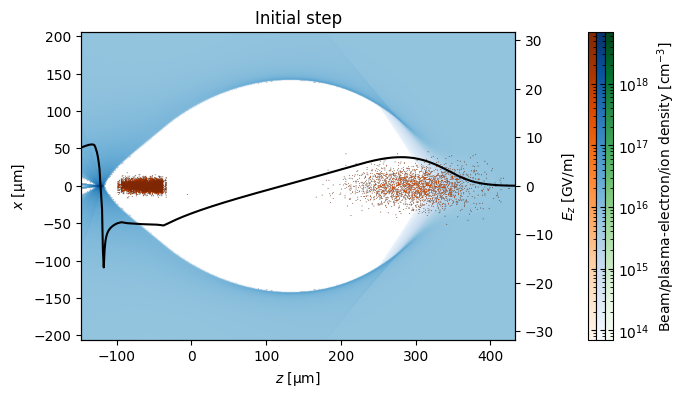

In [8]:
# plot the last-stage wakefield
linac.last_stage.plot_wakefield()
linac.last_stage.plot_wake()
linac.last_stage.plot_evolution()

### Plot beam evolution and survey

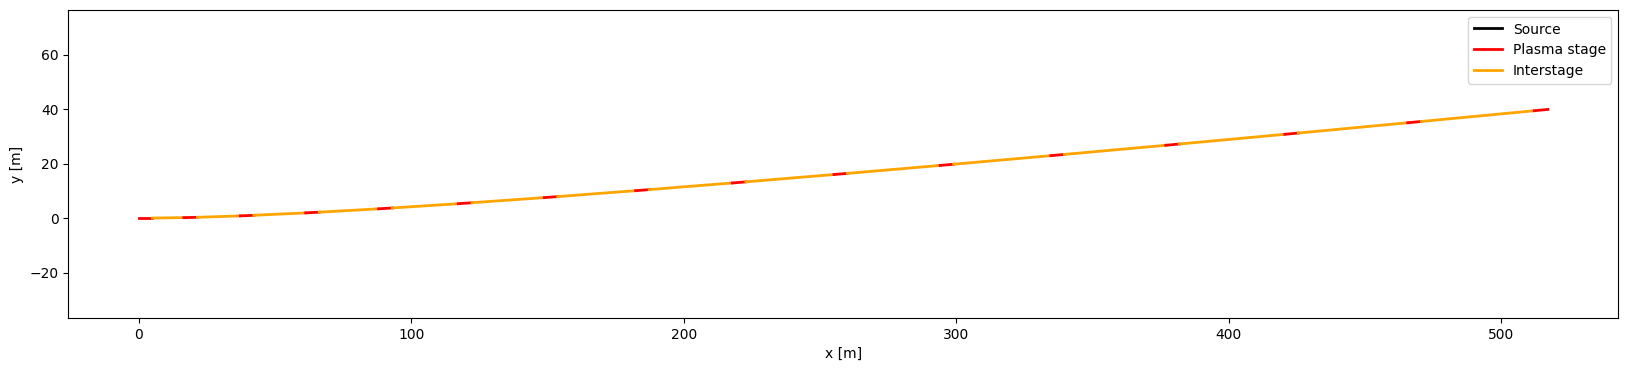

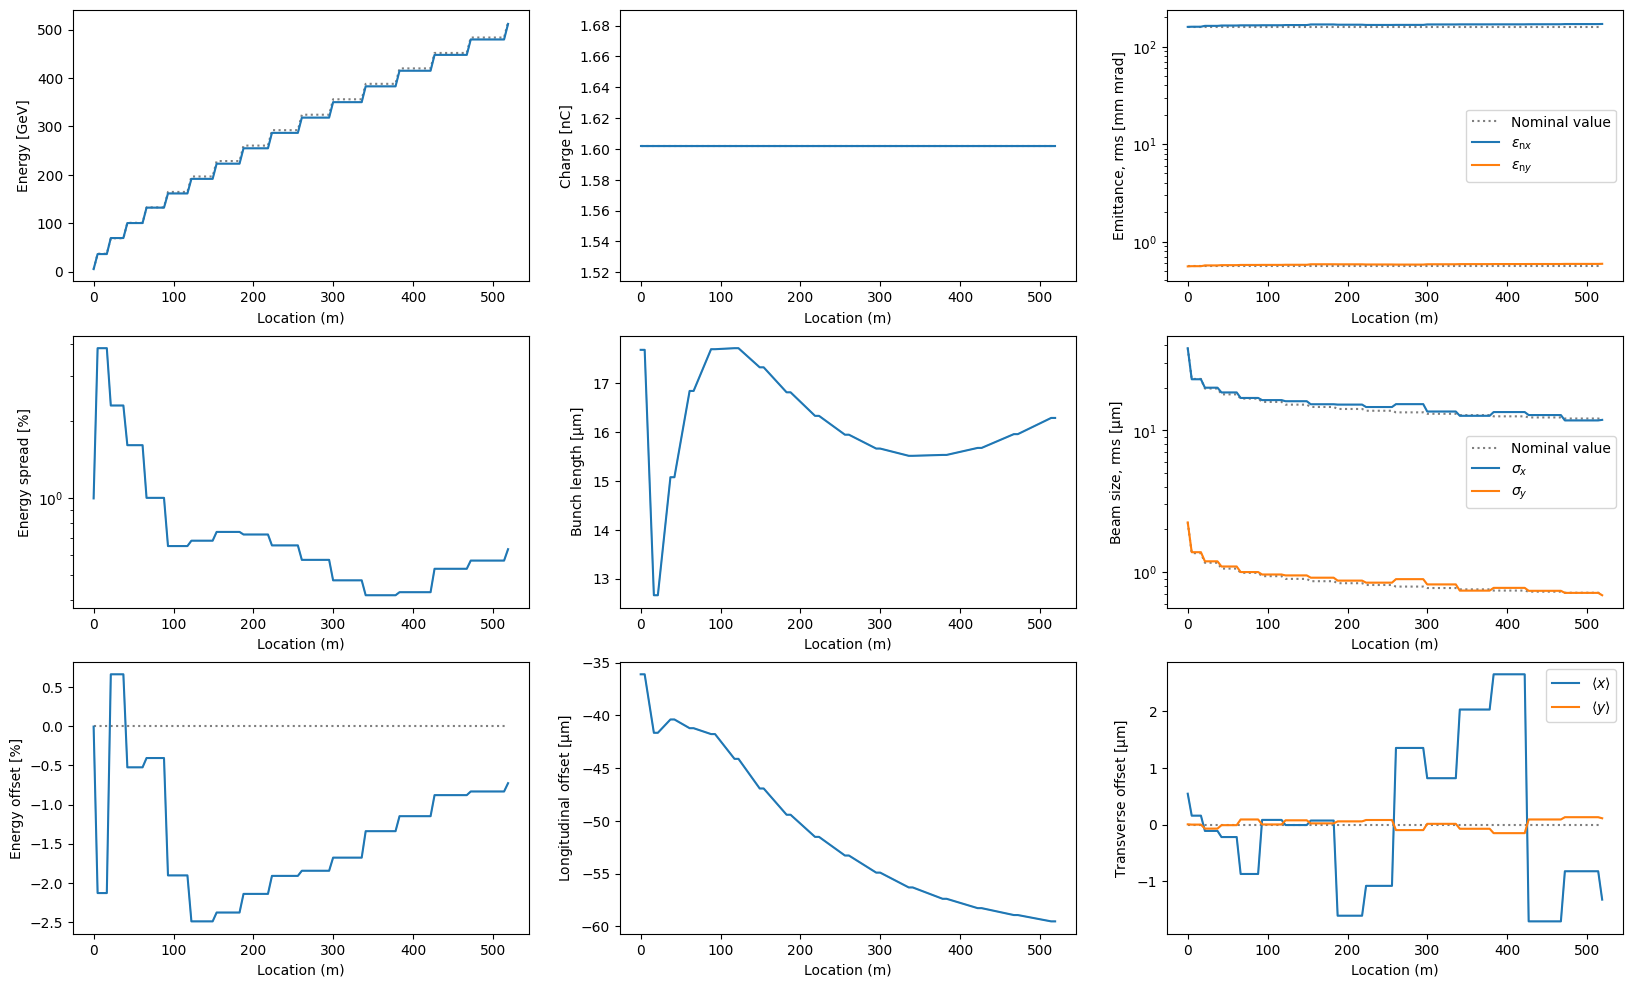

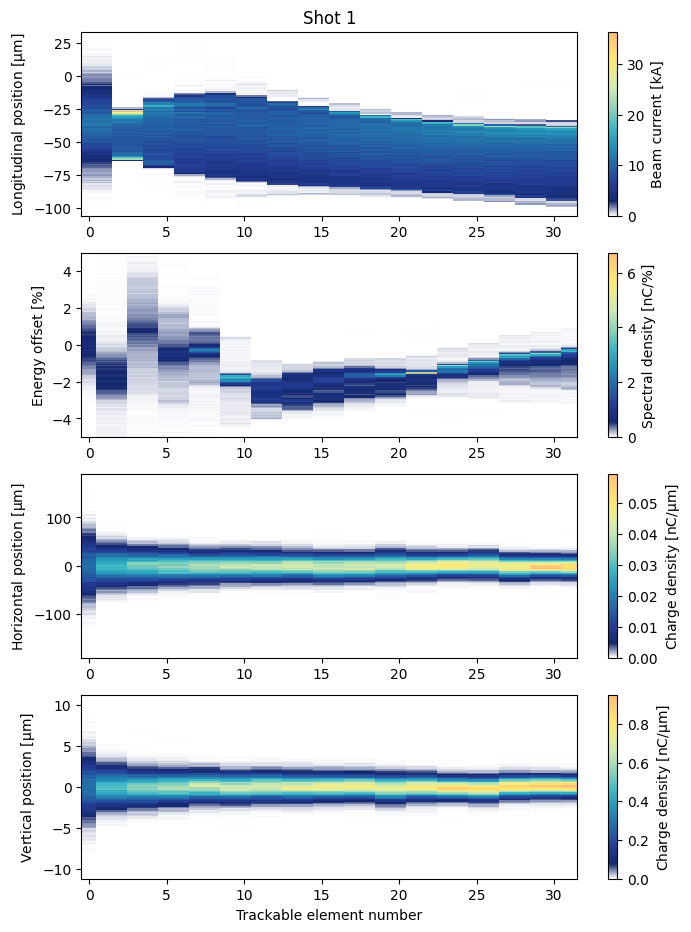

In [9]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
linac.plot_evolution()
linac.plot_waterfalls()

In [ ]:
return
#linac.animate_sideview_x()
#linac.animate_sideview_y()
#linac.animate_phasespace_x()
#linac.animate_phasespace_y()
linac.animate_lps()

![](run_data/linac_example/plots/lps_shot0.gif)